In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score



A metodologia deste estudo consistiu na construção e otimização de modelos de árvore de decisão aplicados à classificação de tumores de mama, focando no equilíbrio entre desempenho preditivo e simplicidade estrutural. O benchmark escolhido contém informações de diagnóstico de massas mamárias.

- Atributos: Foram utilizadas 30 variáveis preditoras numéricas, incluindo métricas de raio, textura, perímetro e área (médias, erros padrão e piores valores).
- Classes: O alvo da classificação é binário: maligno ou benigno.
- Divisão dos Dados: Para garantir a robustez da avaliação, os dados foram particionados em três conjuntos: 64% para treinamento, 16% para validação (utilizado na busca de hiperparâmetros) e 20% para teste final (dados não vistos).


O algoritmo base escolhido foi a Árvore de Decisão (Decision Tree Classifier). 

A otimização foi realizada através de uma busca em grelha (Grid Search) sobre dois hiperparâmetros:

1- Profundidade Máxima (max_depth): Intervalo de 1 a 20.

2- Mínimo de Amostras para Divisão (min_samples_split): Intervalo de 2 a 50, com passo de 2.

Para cada combinação da grelha, o modelo foi treinado no conjunto de treino e avaliado no conjunto de validação sob duas métricas:

- Erro de Classificação (E): Definido como 1− Acurácia.
- Complexidade (C): Mensurada pelo número total de nós da árvore gerada.

O problema foi tratado como uma otimização multiobjetivo, visando minimizar simultaneamente o erro e a complexidade. 
Como estas métricas possuem escalas diferentes, os valores de complexidade foram normalizados.

Utilizou-se a técnica de Soma Ponderada para agregar os objetivos em uma única função escalar (MO):

min(MO)=(pesos_err*Erro)+(pesos_complexidade*compl_norm)

Onde:

•	pesos_err variou de 0 a 1 (com incrementos de 0.05).

•	pesos_complexidade= 1- pesos_err

Para selecionar os modelos de maior interesse, aplicou-se o conceito de Dominância de Pareto. 
Uma solução (modelo) é considerada "dominada" se existir outra configuração que apresente, simultaneamente, um erro menor e uma complexidade reduzida (ou pelo menos um deles melhor, sem piorar o outro).

Por fim treinamos o modelo com os resultados de HP e verificamos o desempenho com os dados de treino.


In [2]:
# 1. Preparação dos Dados
data = load_breast_cancer()

#20% dos dados para teste
X_temp, X_test, y_temp, y_test = train_test_split(data.data, data.target, test_size=0.20, random_state=42, stratify=data.target)

#dos 80 do treino 20% vão para validação 
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.20, random_state=42, stratify=y_temp)

#64% treino / 16% validação/ 20% teste

In [3]:
np.set_printoptions(linewidth=120, threshold=1000)
#print(data)
print(f"Features: {data.feature_names}")
print(f"Classes: {data.target_names}")
print(f"Total samples: {X_train.shape[0]}")

Features: ['mean radius' 'mean texture' 'mean perimeter' 'mean area' 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension' 'radius error' 'texture error' 'perimeter error'
 'area error' 'smoothness error' 'compactness error' 'concavity error' 'concave points error' 'symmetry error'
 'fractal dimension error' 'worst radius' 'worst texture' 'worst perimeter' 'worst area' 'worst smoothness'
 'worst compactness' 'worst concavity' 'worst concave points' 'worst symmetry' 'worst fractal dimension']
Classes: ['malignant' 'benign']
Total samples: 364


In [4]:
# 2. Definição da Grelha (Grid) dos hiperparametros que serao testados
depths_grid = np.arange(1, 21)        # 1 a 20
samples_grid = np.arange(2, 51, 2)    # 2 a 50

results = []

In [5]:
samples_grid

array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50])

In [6]:
#Iremos otimizar a taxa de acerto e a complexidade do modelo e neste caso vou considerar como complexidade do modelo o numero de nós
# 3. Execução da Busca em Grelha
for depth in depths_grid:
    for min_samples in samples_grid:
        model = DecisionTreeClassifier(max_depth=depth, min_samples_split=min_samples, random_state=42)
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_val)
        error = 1 - accuracy_score(y_val, y_pred)
        complexity = model.tree_.node_count
        
        results.append((error, complexity, depth, min_samples))

errors, complexities, depths, samples = zip(*results)

In [7]:
max(complexities)

31

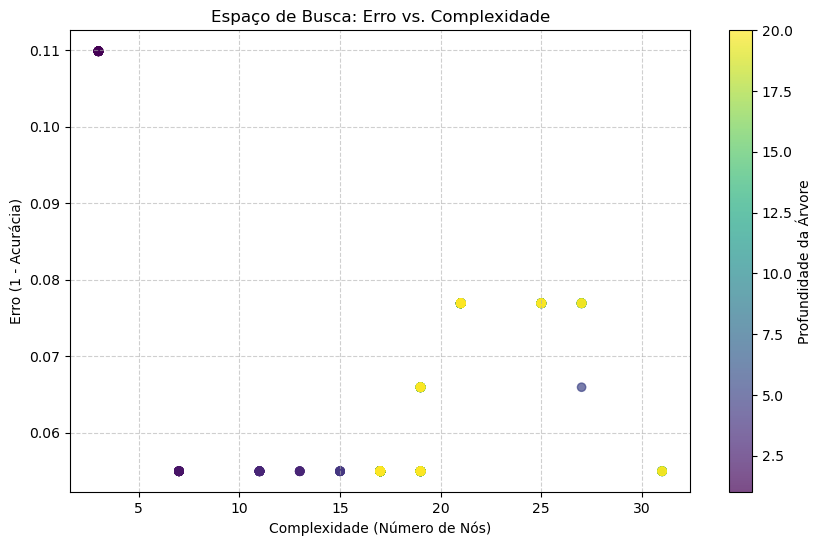

In [8]:
# 4. Visualização 
plt.figure(figsize=(10, 6))
scatter = plt.scatter(complexities, errors, c=depths, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Profundidade da Árvore')
plt.xlabel('Complexidade (Número de Nós)')
plt.ylabel('Erro (1 - Acurácia)')
plt.title('Espaço de Busca: Erro vs. Complexidade')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [9]:
# Transformar em arrays para facilitar contas
err_arr = np.array(errors)
comp_arr = np.array(complexities)

# Normalizar complexidade para escala 0-1
comp_norm = (comp_arr - comp_arr.min()) / (comp_arr.max() - comp_arr.min())

#a normalização é importante devido a escala, o erro varia entre 0 e 1
#portanto faria sentido complexidade estar na mesma escala para a soma ponderada

# Gerar uma lista de pesos (de 0 a 1 em passos de 0.05)(Peso Erro, Peso Complexidade)
pesos_erro = np.linspace(0, 1, 21)
pareto_points_idx = []


for w_err in pesos_erro:
    w_comp = 1.0 - w_err
    # Função Objetivo Multiobjetivo (MO)
    MO = (w_err * err_arr) + (w_comp * comp_norm)
    
    best_idx = np.argmin(MO)
    if best_idx not in pareto_points_idx:
        pareto_points_idx.append(best_idx) #são pontos otimos para algum vetor de peso
    
    pareto_points_idx = sorted(pareto_points_idx, key=lambda i: complexities[i])
    print(f"Peso Erro: {w_err*100:>3.0f}% | Peso Comp: {w_comp*100:>3.0f}%")
    print(f" -> Melhor Resultado: Erro={errors[best_idx]:.4f}, Nós={complexities[best_idx]}")
    print("-" * 50)
    

Peso Erro:   0% | Peso Comp: 100%
 -> Melhor Resultado: Erro=0.1099, Nós=3
--------------------------------------------------
Peso Erro:   5% | Peso Comp:  95%
 -> Melhor Resultado: Erro=0.1099, Nós=3
--------------------------------------------------
Peso Erro:  10% | Peso Comp:  90%
 -> Melhor Resultado: Erro=0.1099, Nós=3
--------------------------------------------------
Peso Erro:  15% | Peso Comp:  85%
 -> Melhor Resultado: Erro=0.1099, Nós=3
--------------------------------------------------
Peso Erro:  20% | Peso Comp:  80%
 -> Melhor Resultado: Erro=0.1099, Nós=3
--------------------------------------------------
Peso Erro:  25% | Peso Comp:  75%
 -> Melhor Resultado: Erro=0.1099, Nós=3
--------------------------------------------------
Peso Erro:  30% | Peso Comp:  70%
 -> Melhor Resultado: Erro=0.1099, Nós=3
--------------------------------------------------
Peso Erro:  35% | Peso Comp:  65%
 -> Melhor Resultado: Erro=0.1099, Nós=3
-------------------------------------------

In [21]:
pesos_erro

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85,
       0.9 , 0.95, 1.  ])

In [10]:
#são as melhores soluções de compromisso (também chamadas de Ótimas de Pareto ou eficientes) onde não é possível melhorar 
# um objetivo sem piorar pelo menos um outro objetivo,
def pareto_front(errors, complexities):
    n = len(errors)
    is_pareto = np.ones(n, dtype=bool)

    for i in range(n):
        for j in range(n):
            if (
                (errors[j] <= errors[i]) and
                (complexities[j] <= complexities[i]) and
                ((errors[j] < errors[i]) or (complexities[j] < complexities[i]))
            ):
                is_pareto[i] = False
                break
    return is_pareto


In [11]:
is_pareto = pareto_front(err_arr, comp_arr)

pareto_errors = err_arr[is_pareto]
pareto_complexities = comp_arr[is_pareto]
pareto_depths = np.array(depths)[is_pareto]
pareto_samples = np.array(samples)[is_pareto]


In [12]:
pareto_errors

array([0.10989011, 0.10989011, 0.10989011, 0.10989011, 0.10989011, 0.10989011, 0.10989011, 0.10989011, 0.10989011,
       0.10989011, 0.10989011, 0.10989011, 0.10989011, 0.10989011, 0.10989011, 0.10989011, 0.10989011, 0.10989011,
       0.10989011, 0.10989011, 0.10989011, 0.10989011, 0.10989011, 0.10989011, 0.10989011, 0.05494505, 0.05494505,
       0.05494505, 0.05494505, 0.05494505, 0.05494505, 0.05494505, 0.05494505, 0.05494505, 0.05494505, 0.05494505,
       0.05494505, 0.05494505, 0.05494505, 0.05494505, 0.05494505, 0.05494505, 0.05494505, 0.05494505, 0.05494505,
       0.05494505, 0.05494505, 0.05494505, 0.05494505, 0.05494505])

In [13]:
weighted_pareto_idx = list(set(pareto_points_idx))
weighted_pareto_idx

[0, 25]

In [ ]:
#Pelo o que percebo esses pontos são ótimos escalarizados
"""Sendo 0 solução ótima quando a complexidade domina, 25	solução de compromisso intermediária"""
for i in weighted_pareto_idx:
    print(f"Índice {i}")
    print(f"Erro: {errors[i]:.4f}")
    print(f"Nós: {complexities[i]}")
    print(f"max_depth: {depths[i]}")
    print(f"min_samples_split: {samples[i]}")
    print("-" * 40)


Índice 0
Erro: 0.1099
Nós: 3
max_depth: 1
min_samples_split: 2
----------------------------------------
Índice 25
Erro: 0.0549
Nós: 7
max_depth: 2
min_samples_split: 2
----------------------------------------


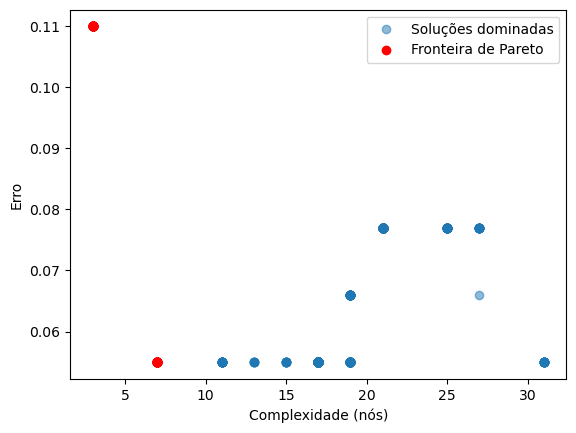

In [22]:
plt.scatter(comp_arr, err_arr, alpha=0.5, label="Soluções dominadas")
plt.scatter(pareto_complexities, pareto_errors, color="red", label="Fronteira de Pareto")
plt.xlabel("Complexidade (nós)")
plt.ylabel("Erro")
plt.legend()
plt.show()

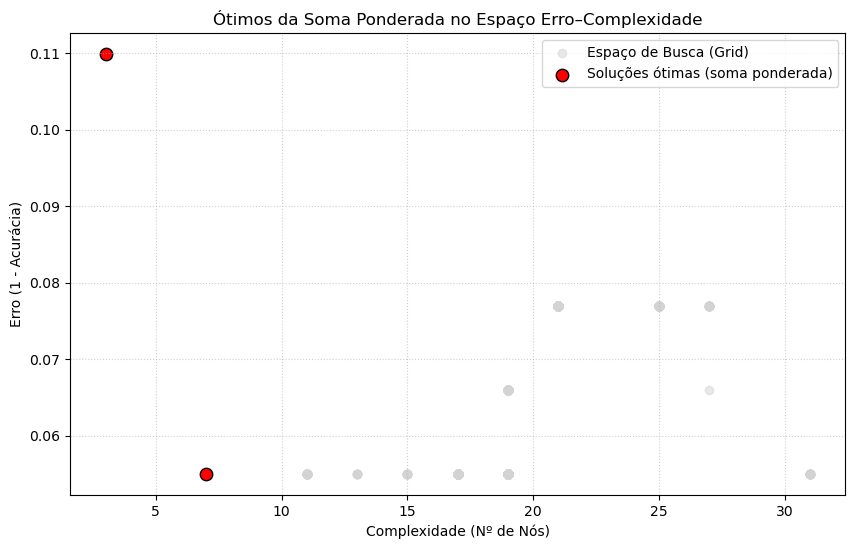

In [16]:
#Agora preciso executar uma função que avalie os valores MO = (w_err * err_arr) + (w_comp * comp_norm) e verificar as soluções que formam a fronteira de Pareto
# e encontrar o ponto de compromisso que não necessariamente é o ponto 5050

plt.figure(figsize=(10, 6))

# Todos os modelos testados (cinza)
plt.scatter(complexities, errors, c='lightgrey', alpha=0.5, label='Espaço de Busca (Grid)')

# Destacar os pontos da Fronteira encontrados pela variação de pesos
px = [complexities[i] for i in pareto_points_idx]
py = [errors[i] for i in pareto_points_idx]

plt.scatter(px, py, c='red', edgecolors='black', s=80, label='Soluções ótimas (soma ponderada)')


plt.xlabel('Complexidade (Nº de Nós)')
plt.ylabel('Erro (1 - Acurácia)')
plt.title('Ótimos da Soma Ponderada no Espaço Erro–Complexidade')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

A aplicação do método das somas ponderadas revelou apenas três soluções distintas ótimas ao longo de todo o intervalo de pesos considerados, indicando que essas soluções dominam amplas regiões do espaço de preferências. Este comportamento é consistente com a natureza convexa da escalarização, que não garante a recuperação completa da fronteira de Pareto.

In [17]:
#O índice 25 parece ser o ponto ideal pois reduz o erro drasticamente (de 10% para 4%) com um aumento muito pequeno em nós (de 3 para 7)
# O que se faz aqui é retreinar o modelo com os dados de treino + validação para testar nos dados de teste
#Neste caso neste treino com mais dados vamos utilizar os hiperparametros do ponto 25 max_depth: 2
#min_samples_split: 2 e por fim, verificamos essa decision tree com os dados de teste

# Escolhendo os parâmetros da solução de compromisso (Índice 25)
best_params = {
    'max_depth': depths[25],
    'min_samples_split': samples[25]
}

In [18]:
#  Retreinar o modelo com Treino + Validação (X_temp)
final_model = DecisionTreeClassifier(
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    random_state=42
)
final_model.fit(X_temp, y_temp)

DecisionTreeClassifier(max_depth=2, random_state=42)

In [19]:
#Avaliação Final no Teste
y_test_pred = final_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_error = 1 - test_accuracy
test_complexity = final_model.tree_.node_count

print(f"=== PERFORMANCE FINAL NO TESTE (Solução de Compromisso) ===")
print(f"Hiperparâmetros: {best_params}")
print(f"Erro no Teste: {test_error:.44f}")
print(f"Complexidade Final: {test_complexity} nós")


=== PERFORMANCE FINAL NO TESTE (Solução de Compromisso) ===
Hiperparâmetros: {'max_depth': 2, 'min_samples_split': 2}
Erro no Teste: 0.10526315789473683626198408092022873461246490
Complexidade Final: 7 nós


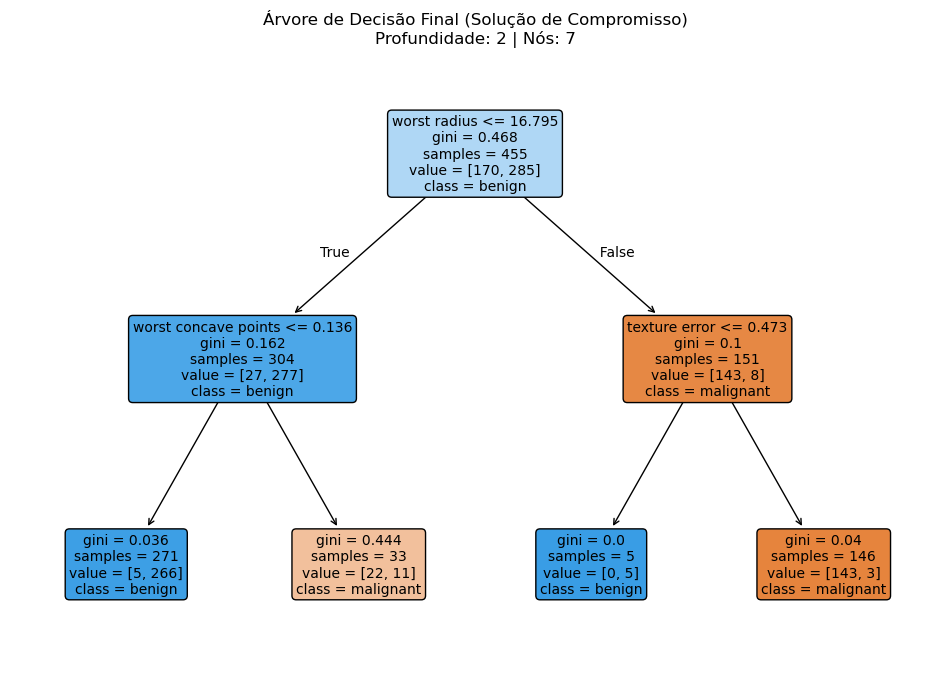

In [20]:
# 1. Configurar o tamanho da imagem
plt.figure(figsize=(12, 8))

# 2. Plotar a árvore
plot_tree(
    final_model, 
    feature_names=data.feature_names,  # Nome das colunas (ex: mean radius)
    class_names=data.target_names,   # Nome das classes (malignant, benign)
    filled=True,                     # Cores para indicar a classe predominante
    rounded=True,                    # Bordas arredondadas para melhor estética
    fontsize=10
)

plt.title(f"Árvore de Decisão Final (Solução de Compromisso)\nProfundidade: {best_params['max_depth']} | Nós: {test_complexity}")
plt.show()